 # Airbnb case

## Data Load and Prepare

In [88]:
import pandas as pd
import numpy as np
import pandas_profiling
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

In [60]:
df=pd.read_csv('../data/listings.csv', index_col='id')
df.head(3)


,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
9784567,nice Room in Amsterdam,27280608,Petra,NaN,Bijlmer-Oost,52.323369,4.977730,Private room,95,1,5,2016-06-27,0.81,3,365
13163805,Best cost benefit room near a metro station,35491461,Phillip,NaN,Bijlmer-Oost,52.315635,4.978166,Private room,60,1,4,2016-06-27,4.00,1,77
3719167,Nice room in A´dam SE near nature & heart centre,18991270,Maria,NaN,Bijlmer-Oost,52.316711,4.986618,Private room,45,5,11,2016-01-02,0.48,1,23


In [61]:
df['last_review']=pd.to_datetime(df['last_review'], yearfirst=True)
df.dtypes

name                                      object
host_id                                    int64
host_name                                 object
neighbourhood_group                      float64
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
dtype: object

## 3. Find ROI

### Gain of investment
Let's estimate investment gain for renting out a property for entire year - as average price per night times 365 days. <br>
First, let's check how skewed price is - so to decide whether mean or median price would be a better measure. It seems we have a number of exceptionally highly priced properties, median seems to be a better measure of how much we'll be able to charge.

In [62]:
df['price'].describe()

count    13849.000000
mean       132.837100
std        105.267487
min         10.000000
25%         89.000000
50%        115.000000
75%        150.000000
max       8616.000000
Name: price, dtype: float64

In [63]:
df_roi = pd.DataFrame({'measure':['mean_price', 'median_price', 'gain_yr_med'],
                       'overall': [df['price'].describe()[1], df['price'].describe()[5], df['price'].describe()[5]*365],
                      'house': [df[df['room_type']=='Entire home/apt']['price'].describe()[1], df[df['room_type']=='Entire home/apt']['price'].describe()[5], df[df['room_type']=='Entire home/apt']['price'].describe()[5]*365],
                      'room': [df[df['room_type']=='Private room']['price'].describe()[1], df[df['room_type']=='Private room']['price'].describe()[5],df[df['room_type']=='Private room']['price'].describe()[5]*365],
                      'shared_room': [df[df['room_type']=='Shared room']['price'].describe()[1], df[df['room_type']=='Shared room']['price'].describe()[5], df[df['room_type']=='Shared room']['price'].describe()[5]*365],
                      })
df_roi

,measure,overall,house,room,shared_room
0,mean_price,132.8371,145.809652,79.106938,66.521127
1,median_price,115.0000,125.000000,73.000000,46.000000
2,gain_yr_med,41975.0000,45625.000000,26645.000000,16790.000000


Table above gives it's more profitable to rent out for a year entire house, but only breaching max days rule - now 30. <br>
So, we'll estimate also the next best alternative - rent out a private room (with registered B&B).  <br>
In both cases taxes on rent will be not included in calculations.

### Cost of investment
Despite high properties prices, it is possible to find on funda an appartment (or studio) close to the center for 400k euro. This yields monthly mortgage (according to funda) 1500euro, or 18k euro annualy. <br>
Adding property tax estimate of 400 euro/year, and facilities plus service cost (upper) estimate of 300 euro/mnth, or 3600 per year, we'll get: <br>
**Cost of investment = 18000 + 4000 = 22000 euro/year**

### ROI
According to the formula **ROI = (Gain - Cost)/Cost** <br>

In [64]:
roi_house = (df_roi.iloc[2, 2] - 22000)/22000
roi_room = (df_roi.iloc[2, 3] - 22000)/22000
print('ROI entire appartment = {:3.1%}'.format(roi_house), '\n', 
      'ROI private room = {:3.1%}'.format(roi_room))

ROI entire appartment = 107.4% 
 ROI private room = 21.1%


## 2. Gemeente Rules Violations and illegal gain

Looking at the data, there are 2 major violations of the existing rules:
- Entire house is rented out for more than 60 days in a year [<a href=https://www.amsterdam.nl/wonen-leefomgeving/wonen/particuliere/>Particuliere vakantieverhuur</a>]
- One host rents out more than 1 object [<a href=https://www.amsterdam.nl/wonen-leefomgeving/wonen/particuliere/>Particuliere vakantieverhuur</a>] in both house and rooms categories

### Assumptions and remarks:
- For breaching 60 days rule, we look at availability_365 column, assuming this is intended amount of days to rent (in this way equating intended and actual breaching of the rule). 
- We assume availability_365 gives the actual rented days in a year (due to lack of better data on actual rented days, or data on already booked days). This should give underestimated actual illegal gain (of > 60 days), for already reserved days are not accounted for.
- It is noticed some officially registered hotels are present in the dataset (e.g. Faralda Crane) - for them of course other rules apply. According Airbnb, this is OK [<a href=https://www.airbnb.nl/help/article/18/who-can-host-on-airbnb>Who can host on Airbnb</a>], but is difficult to filter this out from dataset. This should give of course overestimated illegal gain.
- In some cases it seems possible multiple advertisements are made for the same object (with error in coordinates, pointing e.g. at a road), often in different categories (entire house and private room), in some cases 0 days are set available for 1 of the 2 objects. This cases are accounted for as violations - first, it is at best poor maintainance of records by host (on airbnb), second, it is difficult to filter out these cases.
- In a few cases minimum nights requirements (up to ~3 yrs) suggest long rent category, for which other rules should apply. It is ignored here because of size (just 3 cases 1 year or more).
- It is possilbe fixed amount of 800 short stay locations are present in the dataset [<a href=https://www.amsterdam.nl/wonen-leefomgeving/wonen/shortstaybeleid/>Short Stay</a>]. For them other rules should apply, but there is no data at the moment to filter them out.

Let's calculate the illegal gain in the following categories:
- gain renting out for more than 60 days (only entire house, not accounting for multiplicity)
- gain for multiplicity (as total gain from all multiple objects)
- overall gain, that is multiple objects + the rest exceeding 60 days (not a sum of 1 and 2!)

In addition let's add calculated violations gain as % of the entire market gain

In [65]:
cond1=(df.availability_365 > 60) & (df.room_type=='Entire home/apt') #renting out house for more than 60 days
cond2=df.calculated_host_listings_count>1 #multiple objects per host
cond3=cond1 & -cond2 #violation 1, but not 2 (only 1 object per host)

#Let's first get the % of cases where 1 and 2 rules are violated:
n_vio_1 = len(df[cond1])/len(df[df.room_type=='Entire home/apt'])*100
n_vio_2 = len(df[cond2])/len(df)*100

#total gain violating 1st condition (60 days)
gain_1 = sum(df[cond1]['price']*df[cond1]['availability_365']-df[cond1]['price']*60)
#total gain violating  2nd condition (1 object)
gain_2 = sum(df[cond2]['price']*df[cond2]['availability_365'])
#total gain violating 1 object per host condition + total gain violating 60 days (where IS only 1 object per host)
gain_tot = sum(df[cond3]['price']*df[cond3]['availability_365']-df[cond3]['price']*60) + gain_2

#Now, the entrie market gain:
market_gain = sum(df['price']*df['availability_365'])

#put all to dataframe:
df_vio = pd.DataFrame({'Type violation':['>60 days (house)', '>1 object', 'Both'],
                       '% cases': [n_vio_1,n_vio_2,''],
                      'Gain': [gain_1, gain_2, gain_tot],
                       'gain % of entire market': [gain_1/market_gain*100,gain_2/market_gain*100,gain_tot/market_gain*100]
                      })
df_vio

,Type violation,% cases,Gain,gain % of entire market
0,>60 days (house),49.0107,154855834,61.171120
1,>1 object,24.6083,76615874,30.264787
2,Both,,189184478,74.731614


### Conclusion:
Total illegal gain resulted in breaching 1 object per host and max 60 days for entire home/appartment rules is estimated as about **190M euro/year**, which is around 75% of 253M total gain on Airbnb Amsterdam market. <br>
However, it is expected to be overestimated due to a number of high-priced luxurious hotels with high availability present in the dataset.

## 1. Give advices

### Some data "massaging"
- drop empty neighbourhood group col
- add months_exist col = num reviews / reviews per month, approximation of constant review frequency (hardly true in reality)
- add date_start = last review - months exist col : rough estimate of an object openning date
- add months_last_review and months_date_start cols as a number of months passed since last review and openning date respectivelly

In [140]:
from datetime import datetime, timedelta, date

df1 = df.drop(axis=1, columns=['neighbourhood_group'])
df1['months_exist']=df1['number_of_reviews']/df1['reviews_per_month']
df1['months_exist'].fillna(value=0, inplace=True)
#df1['date_start']=pd.Timestamp(df1['months_exist']*30, unit='D')

In [67]:
shape = df1.shape
cols = df1.columns
print(shape, '\n', cols)

(13849, 15) 
 Index(['name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'months_exist'],
      dtype='object')


### Pandas Profiling
Let's get summary statistics report in an html file:

In [77]:
pandas_profiling.ProfileReport(df1).to_file(
outputfile='../output/sum_stat.html')

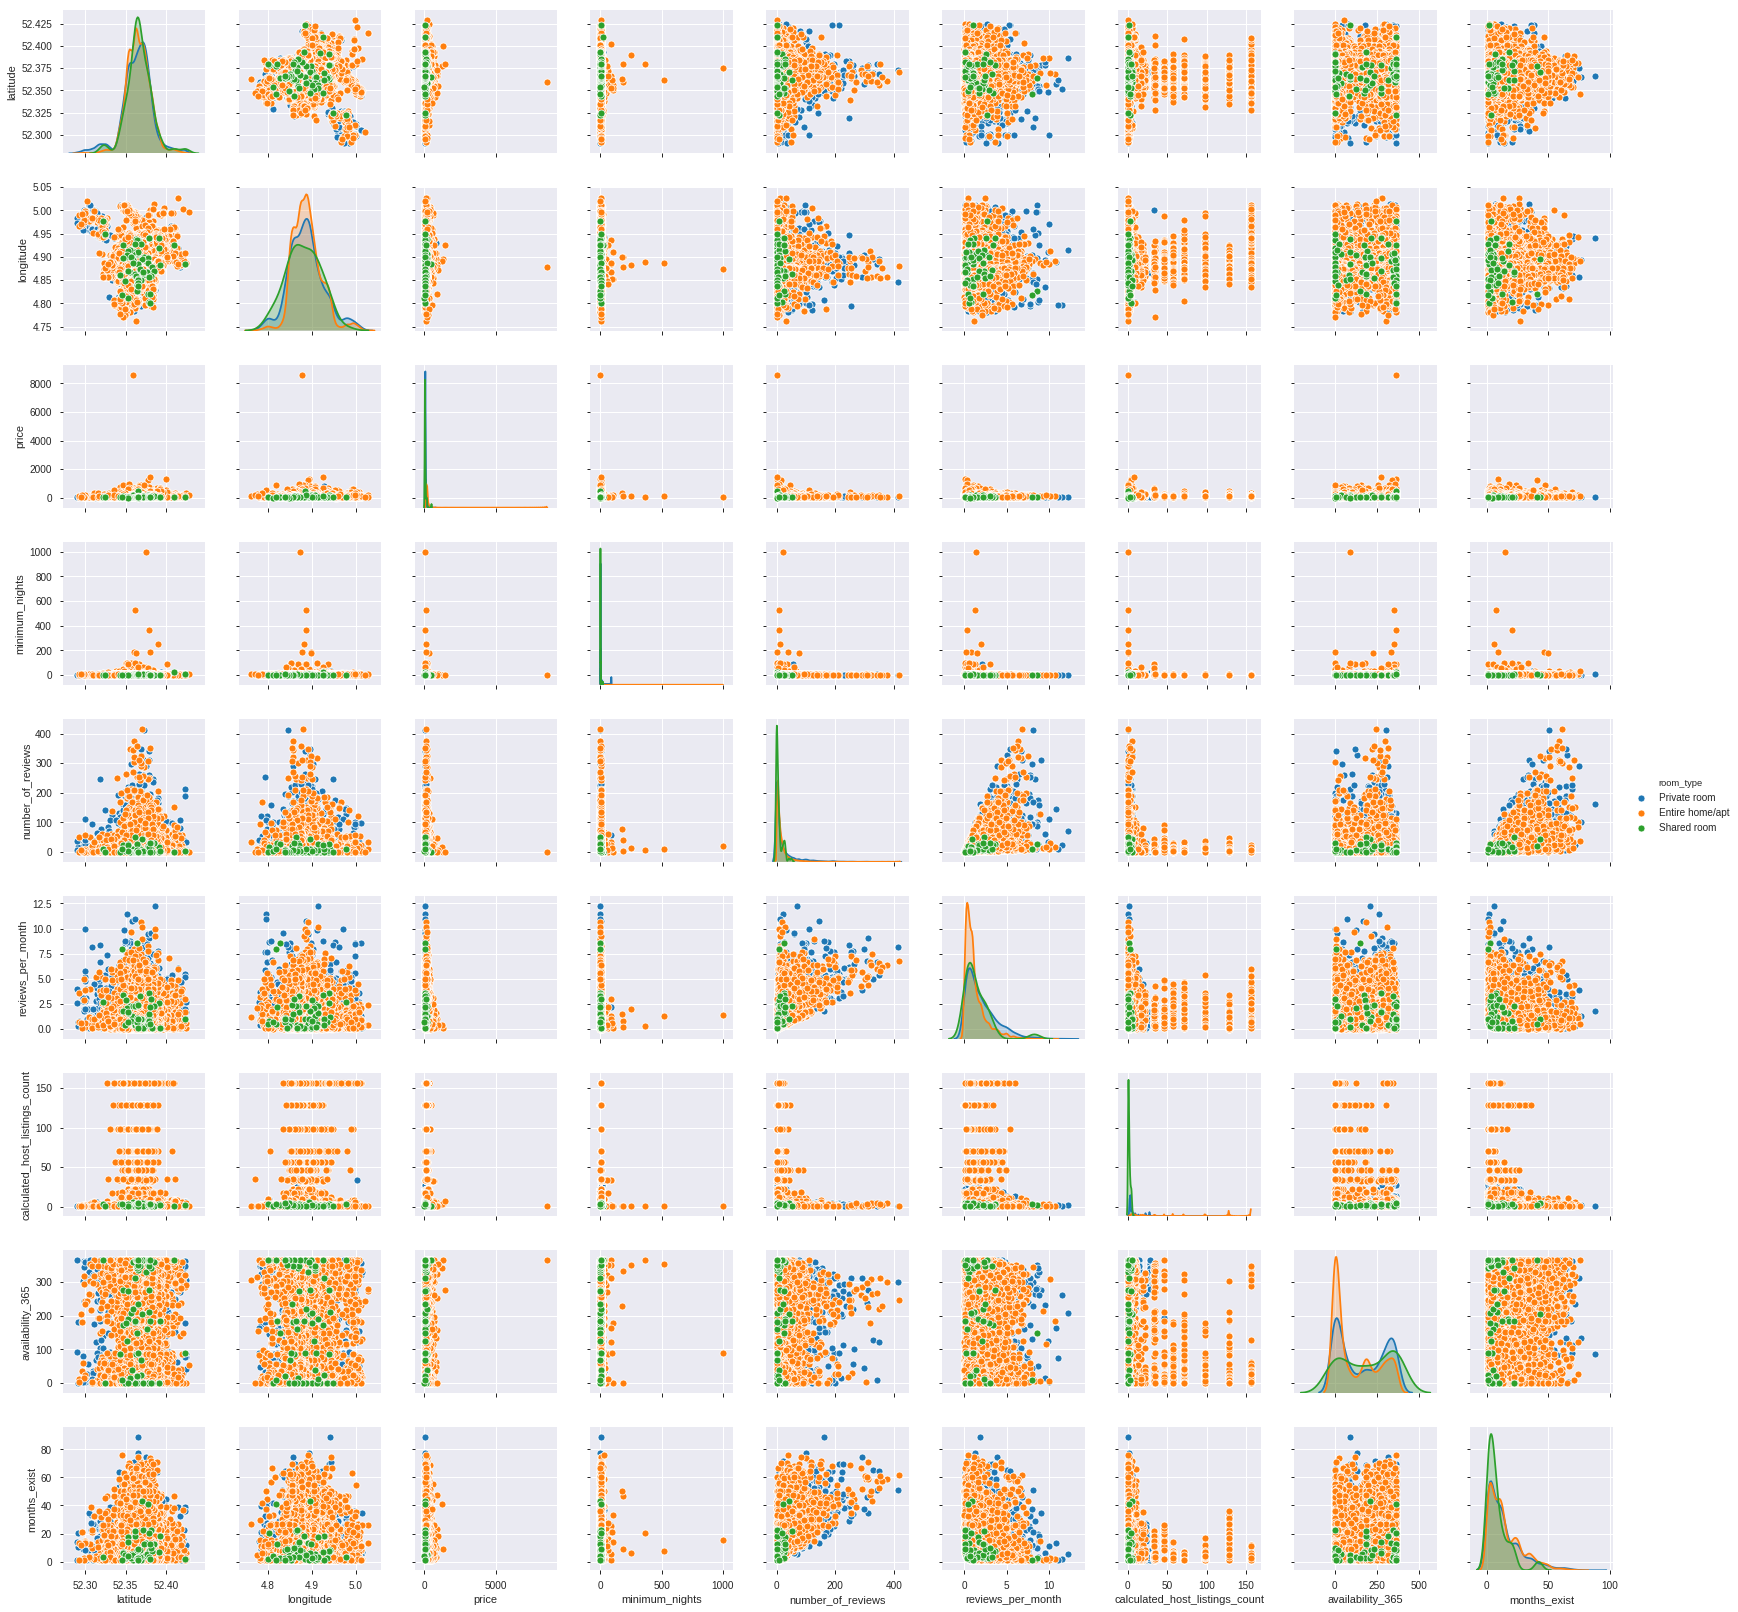

In [130]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

df_corr = df1.drop(axis=1, columns=['name', 'host_id', 'host_name'])
sns.pairplot(df_corr, hue='room_type')

### Phi K correlation
Let's try visualising correlations between interval and non-interval variables: 

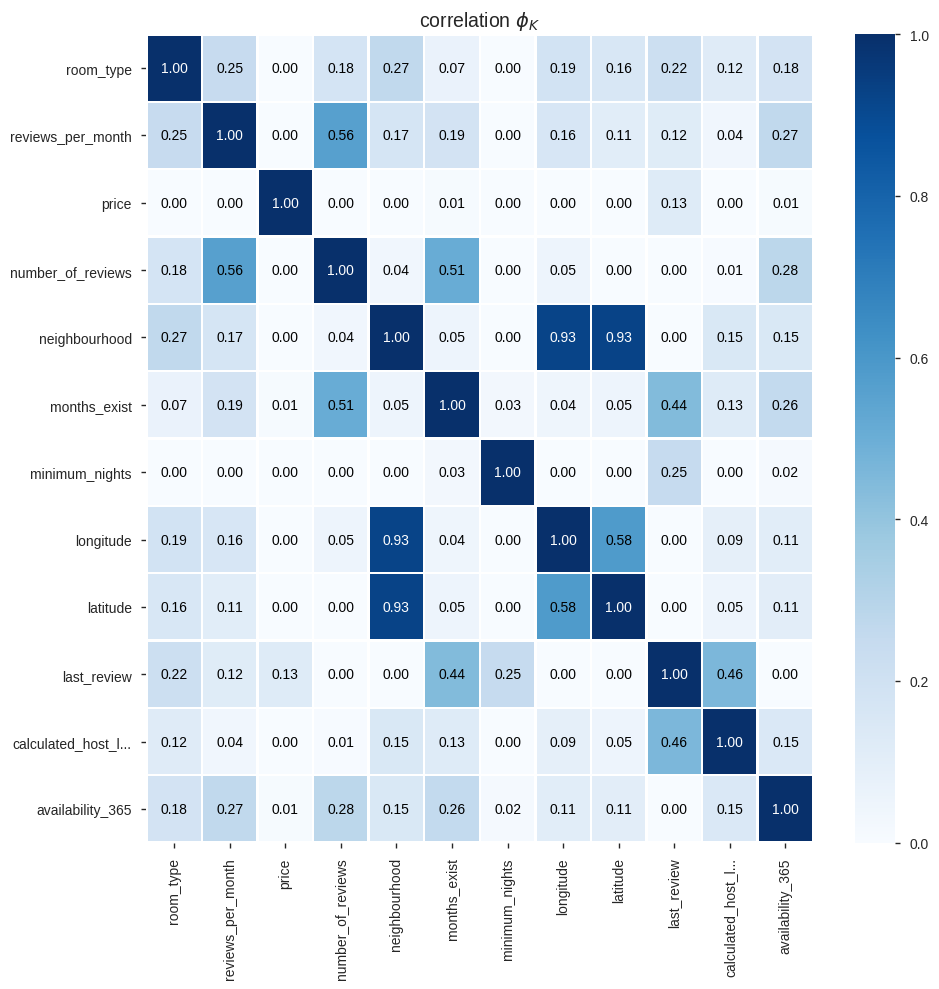

In [89]:
import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

interval_cols=['latitude','longitude','price','minimum_nights',
       'number_of_reviews','reviews_per_month','calculated_host_listings_count',
                                   'availability_365','months_exist']
corr_matrix = df_corr.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(corr_matrix.values, x_labels=corr_matrix.columns, y_labels=corr_matrix.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(10,10))
plt.tight_layout()

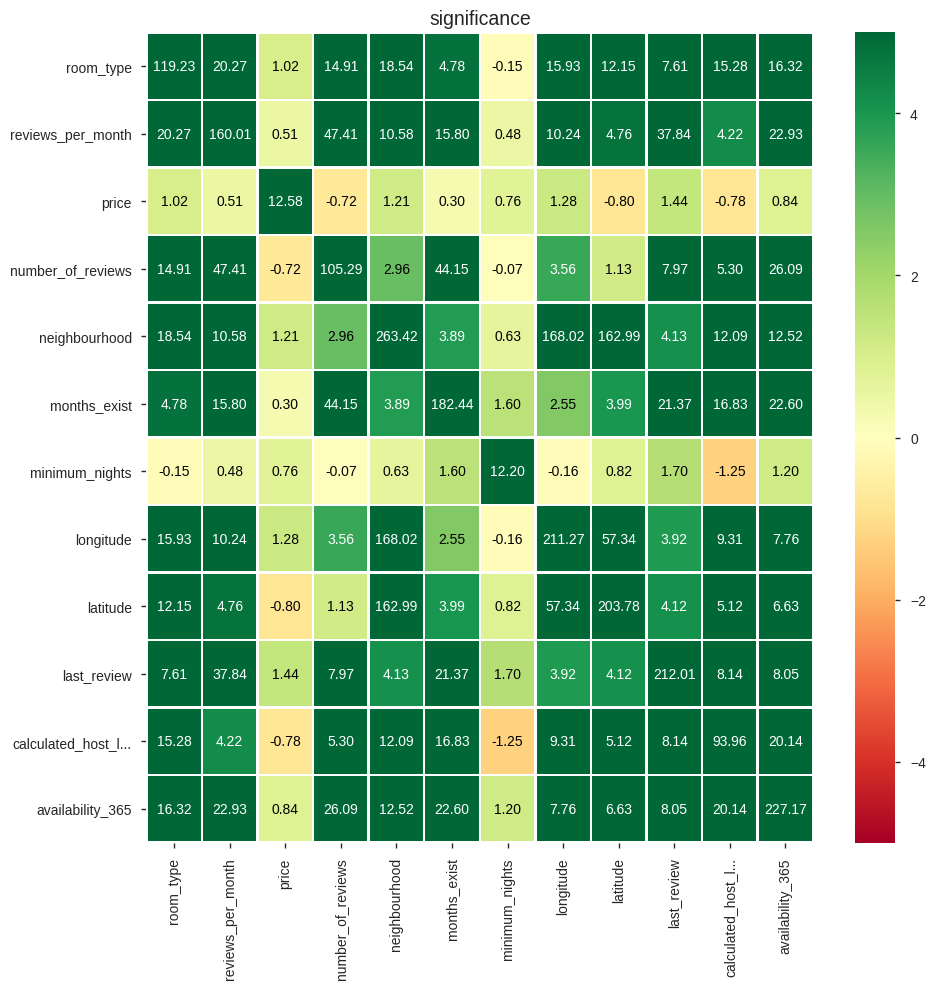

In [90]:
sig_matrix = df_corr.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(sig_matrix.fillna(0).values, x_labels=sig_matrix.columns, 
                        y_labels=sig_matrix.index, vmin=-5, vmax=5, title='significance', 
                        usetex=False, fontsize_factor=1, figsize=(10,10))
plt.tight_layout()

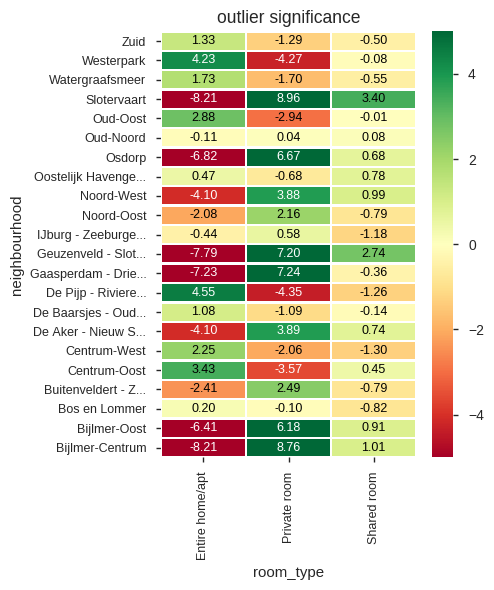

In [104]:
c1 = 'room_type'
c0 = 'neighbourhood'
outlier_signifs, binning_dict = df_corr[[c0,c1]].outlier_significance_matrix(retbins=True)
zvalues = outlier_signifs.values
xlabels = binning_dict[c1] if c1 in binning_dict.keys() else outlier_signifs.columns
ylabels = binning_dict[c0] if c0 in binning_dict.keys() else outlier_signifs.index
xlabel = c1
ylabel = c0

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        x_label=xlabel,y_label=ylabel,
                        vmin=-5, vmax=5, title='outlier significance',
                        identity_layout=False, fontsize_factor=0.9,figsize=(5,6))

More private rooms far from center, more houses/appartments in the center - de Pijp, Westerpark, Oost, Oud-Oost

interval_cols not set, guessing: ['reviews_per_month']


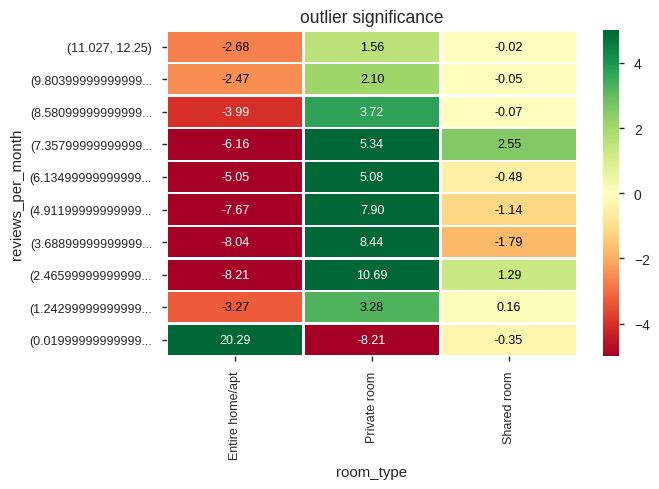

In [109]:
c1 = 'room_type'
c0 = 'reviews_per_month'
outlier_signifs, binning_dict = df_corr[[c0,c1]].outlier_significance_matrix(retbins=True)
zvalues = outlier_signifs.values
xlabels = binning_dict[c1] if c1 in binning_dict.keys() else outlier_signifs.columns
ylabels = binning_dict[c0] if c0 in binning_dict.keys() else outlier_signifs.index
xlabel = c1
ylabel = c0

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        x_label=xlabel,y_label=ylabel,
                        vmin=-5, vmax=5, title='outlier significance',
                        identity_layout=False, fontsize_factor=0.9)

interval_cols not set, guessing: ['calculated_host_listings_count']


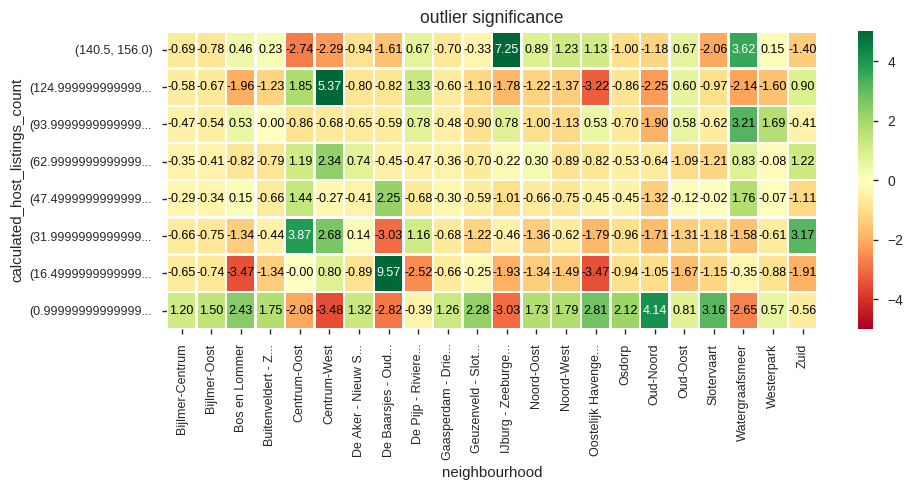

In [103]:
c1 = 'neighbourhood'
c0 = 'calculated_host_listings_count'
outlier_signifs, binning_dict = df_corr[[c0,c1]].outlier_significance_matrix(retbins=True)
zvalues = outlier_signifs.values
xlabels = binning_dict[c1] if c1 in binning_dict.keys() else outlier_signifs.columns
ylabels = binning_dict[c0] if c0 in binning_dict.keys() else outlier_signifs.index
xlabel = c1
ylabel = c0

plot_correlation_matrix(zvalues, x_labels=xlabels, y_labels=ylabels, 
                        x_label=xlabel,y_label=ylabel,
                        vmin=-5, vmax=5, title='outlier significance',
                        identity_layout=False, fontsize_factor=0.9,figsize=(10,5))

Fewer reviews per month for entire hoe/appartment

In [146]:
df_time=pd.DataFrame({'months_exist': round(df1['months_exist']),
                     'Neighbourhood': df1['neighbourhood'],
                     'val': 1})
df_time.to_csv('../data/df_time.csv')

In [157]:
df_time_pivot=df_time.pivot_table(df_time, index='Neighbourhood',columns='months_exist', aggfunc=np.sum, fill_value=0)
df_time_pivot

val                                \
months_exist                           0.0  1.0  2.0  3.0  4.0  5.0  6.0    
Neighbourhood                                                               
Bijlmer-Centrum                          19    8    4    5    0    2    1   
Bijlmer-Oost                             19    8    5    5    3    3    6   
Bos en Lommer                           102   54   33   31   19   24   44   
Buitenveldert - Zuidas                   33   15   17   11    3    7    3   
Centrum-Oost                            208   93   72   66   30   57   58   
Centrum-West                            265  141   95  107   60   66   93   
De Aker - Nieuw Sloten                   21   11    3    7    3    5    5   
De Baarsjes - Oud-West                  427  174  115  142   70   54  111   
De Pijp - Rivierenbuurt                 281  115   81   93   41   38   85   
Gaasperdam - Driemond                    10    7    9    1    0    0    0   
Geuzenveld - Slotermeer                  33    9   11   11    4    5    7   
IJburg - Zeeburgereiland                 89   17   24   15    5    9   11   
Noord-Oost                               53   11    9    8    3    0    9   
Noord-West                               34   15   12   13    6    5   12   
Oostelijk Havengebied - Indische Buurt  147   49   35   40   18   18   34   
Osdorp                                   24    9    4   10    5    4    1   
Oud-Noord                                87   22   19   19    6   10   15   
Oud-Oost                                127   54   46   48   24   18   31   
Slotervaart                              51   24   16   27   16    5   14   
Watergraafsmeer                          93   28   22   18   11    8   19   
Westerpark                              143   72   51   49   31   35   47   
Zuid                                    197   65   64   45   31   22   49   

                                                       ...                 \
months_exist                           7.0  8.0  9.0   ... 68.0 69.0 70.0   
Neighbourhood                                          ...                  
Bijlmer-Centrum                           1    2    0  ...    0    0    0   
Bijlmer-Oost                              1    2    1  ...    0    0    0   
Bos en Lommer                             8   20   28  ...    0    1    0   
Buitenveldert - Zuidas                    3    0    9  ...    0    0    0   
Centrum-Oost                             25   31   27  ...    1    0    0   
Centrum-West                             35   52   44  ...    1    1    1   
De Aker - Nieuw Sloten                    0    1    3  ...    0    0    0   
De Baarsjes - Oud-West                   46   63   77  ...    1    3    0   
De Pijp - Rivierenbuurt                  34   38   58  ...    1    1    1   
Gaasperdam - Driemond                     0    4    1  ...    0    0    0   
Geuzenveld - Slotermeer                   2    1    4  ...    0    0    0   
IJburg - Zeeburgereiland                  4    6    4  ...    0    0    0   
Noord-Oost                                3    1    3  ...    0    0    0   
Noord-West                                1    7    5  ...    0    0    0   
Oostelijk Havengebied - Indische Buurt   11   19   18  ...    0    1    0   
Osdorp                                    0    1    7  ...    0    0    0   
Oud-Noord                                 7    9   10  ...    0    0    0   
Oud-Oost                                 20   20   22  ...    0    0    0   
Slotervaart                               2   12    9  ...    0    0    0   
Watergraafsmeer                           5    6    8  ...    0    0    0   
Westerpark                               15   30   36  ...    0    0    0   
Zuid                                     20   22   34  ...    0    0    0   

                                                                           
months_exist                           71.0 72.0 74.0 75.0 76.0 77.0 89.0  
Neighbourhood                       

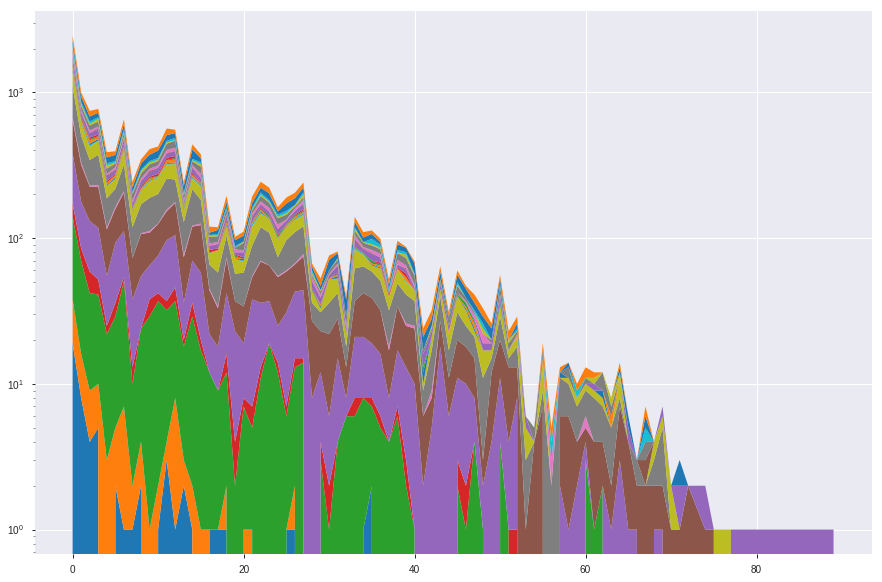

In [208]:
%matplotlib inline
labels=df_time_pivot.index
x=df_time.months_exist.unique()
x.sort()
y=df_time_pivot.val.values
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.set_yscale('log')
ax.legend(labels, loc='upper left')
plt.stackplot(x,y, labels=labels)

(array([5.045e+03, 2.950e+03, 1.624e+03, 7.770e+02, 5.160e+02, 3.090e+02,
        1.000e+02, 5.700e+01, 7.000e+00, 1.000e+00]),
 array([0.08333333, 0.81270492, 1.5420765 , 2.27144809, 3.00081967,
        3.73019126, 4.45956284, 5.18893443, 5.91830601, 6.6476776 ,
        7.37704918]),
 <a list of 10 Patch objects>)

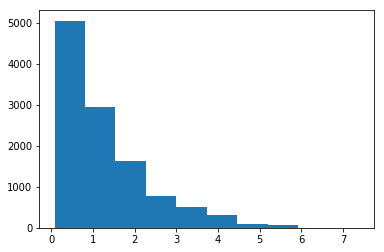

In [70]:
plt.hist(df1['months_exist']/12)

In [71]:
df1['months_exist'].describe()

count    11386.000000
mean        14.801646
std         13.330265
min          1.000000
25%          4.296128
50%         11.111111
75%         22.077922
max         88.524590
Name: months_exist, dtype: float64

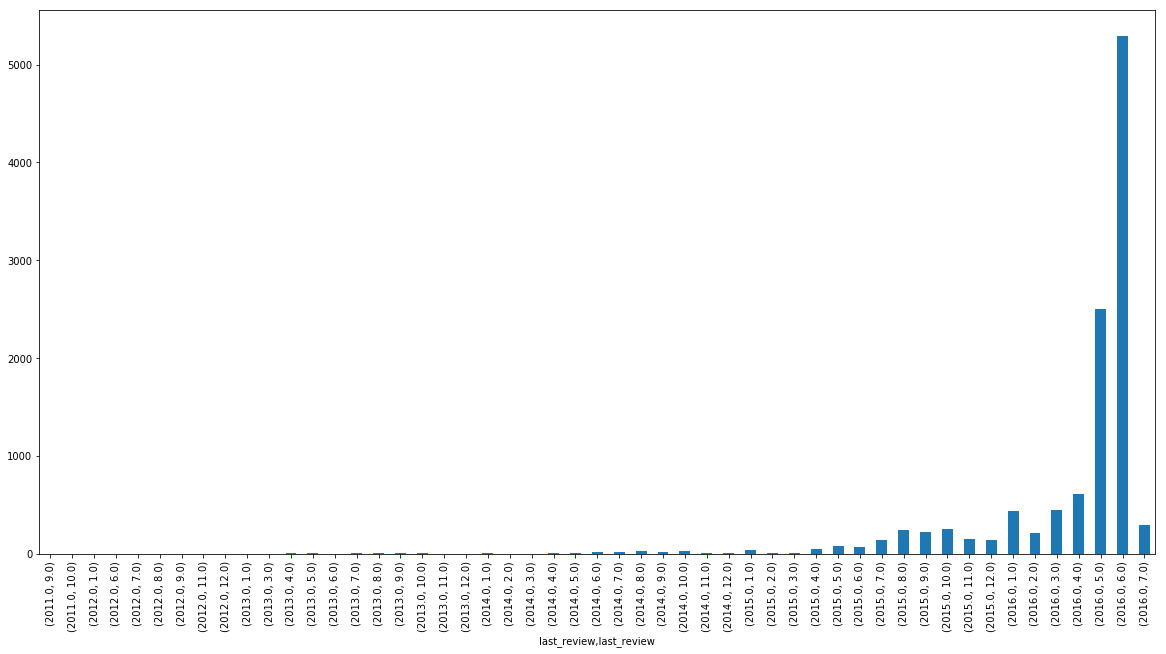

In [75]:
df['last_review'].groupby(by=[df.last_review.dt.year, df.last_review.dt.month]).count().plot(kind='bar', figsize=(20, 10))

[(0, 400)]

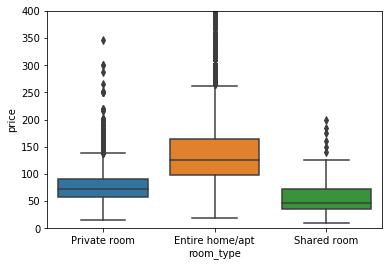

In [28]:
box=sns.boxplot(data=df, x='room_type', y='price')
box.set(ylim=(0, 400))

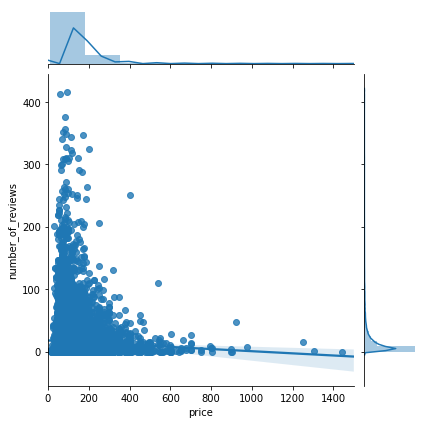

In [22]:
sns.jointplot(df.price, df.number_of_reviews, kind='reg', xlim=(0,1500))

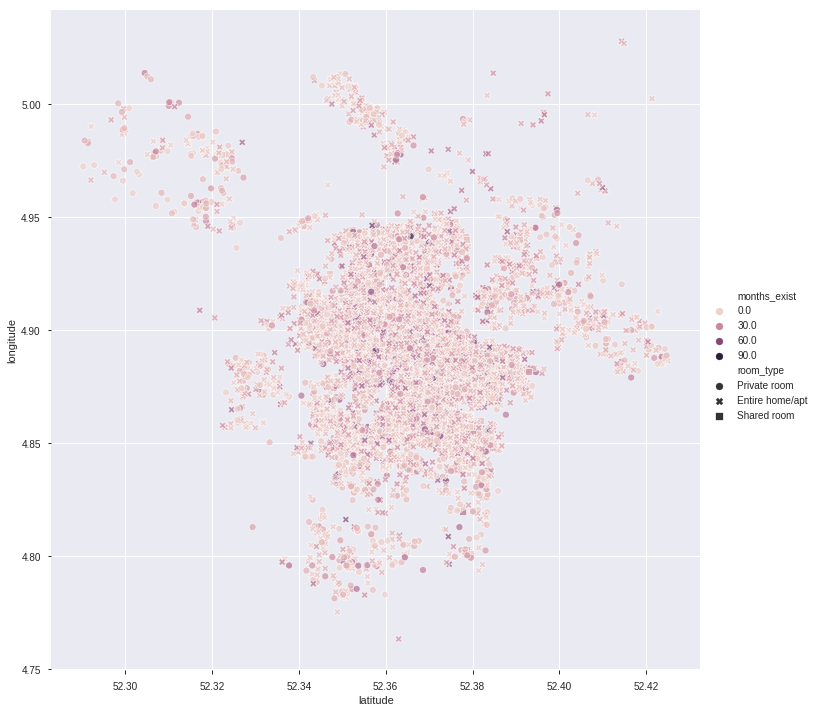

In [131]:
sns.relplot(x='latitude', y='longitude', style='room_type', hue='months_exist', alpha=0.7, data=df1, sizes=(40, 400), height=10)

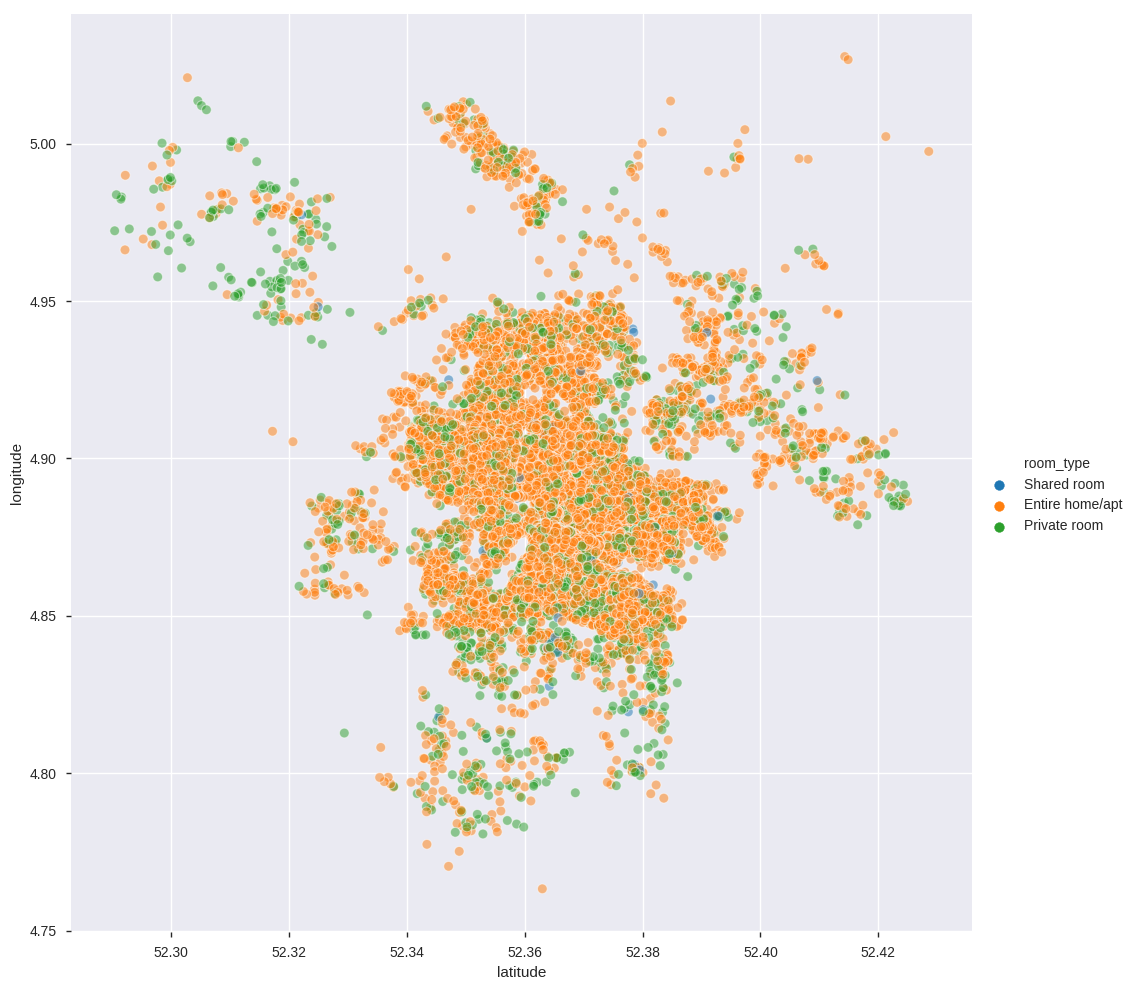

In [127]:
map_type = sns.relplot(x='latitude', y='longitude', hue='room_type', data=df,
                       hue_order=('Shared room', 'Entire home/apt','Private room'), alpha=0.5, sizes=(40, 400), height=10)

## Clustering: let's try

### Affinity Propagation:

In [6]:
X=df.drop(axis=1, columns=['neighbourhood','months_exist','last_review'])
X.columns

Index(['latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [7]:
X['room_type']=X['room_type'].map({'Entire home/apt' :0, 'Private room':1, 'Shared room' :2})

In [8]:
X['reviews_per_month'].fillna(value=0, inplace=True)
X.head()

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,
9784567,52.323369,4.977730,1,95,1,5,0.81,3,365
13163805,52.315635,4.978166,1,60,1,4,4.00,1,77
3719167,52.316711,4.986618,1,45,5,11,0.48,1,23
13188367,52.321204,4.976630,1,35,1,2,1.62,1,10
4831606,52.327270,4.967352,1,39,14,12,0.65,1,338


In [ ]:
%%time
from sklearn.cluster import AffinityPropagation
import numpy as np
cluster=AffinityPropagation()
cluster.fit(X)

### KMeans

In [9]:
from scipy import stats
X=stats.zscore(X)

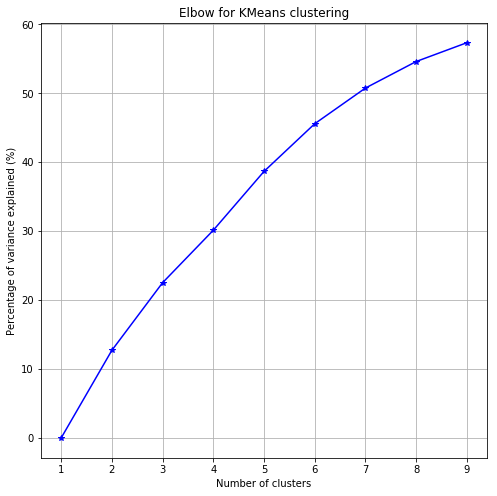

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance
Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]

def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [distance.cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(distance.pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

plot_elbow(kmean, X)
